In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import mutual_info_classif
#from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# load data
trainx = pd.read_csv('microarray_train.csv', index_col=0)
testx = pd.read_csv('microarray_test.csv', index_col=0)

# seprate target from features
trainy = trainx.pop('cancer')
testy = testx.pop('cancer')

# negative values replaced with 0
trainx = trainx.mask(trainx < 0, 0)
trainx = np.log2(trainx + 1)

testx = testx.mask(testx < 0, 0)
testx = np.log2(testx + 1)

# check if features with all zero values
zeros = (trainx==0).sum(axis=0)
allzeros = (zeros == len(trainx.index))
print('num features all zero:', allzeros.sum())

zerocols = list(allzeros[allzeros==True].index)
trainx = trainx.drop(columns=zerocols)
testx = testx.drop(columns=zerocols)

# label encode target, ALL:0, AML:1
le = LabelEncoder()
trainy = le.fit_transform(trainy)
testy = le.transform(testy)
print(f'classes: {le.classes_}')


print(trainx.shape)
trainx.head()

num features all zero: 396
classes: ['ALL' 'AML']
(38, 6733)


,AFFX-BioB-5_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.000000,6.475733,7.643856,7.982994,7.693487,0.000000,6.247928,8.577429,0.000000,...,7.539159,9.000000,0.000000,8.607330,0.00000,9.632995,8.366322,5.209453,7.584963,0.0
1,0.0,0.000000,8.149747,0.000000,6.672425,6.228819,4.321928,7.515700,7.366322,0.000000,...,7.409391,9.710806,0.000000,8.791163,0.00000,9.612868,8.209453,3.584963,6.266787,0.0
2,0.0,0.000000,8.276124,5.087463,7.693487,0.000000,4.321928,7.707359,8.758223,6.409391,...,8.303781,10.228819,5.087463,7.400879,5.72792,10.153552,9.603626,5.392317,7.839204,0.0
3,0.0,8.055282,3.700440,7.312883,5.643856,5.000000,8.507795,7.159871,8.087463,0.000000,...,7.912889,9.707359,7.774787,7.451211,0.00000,9.294621,7.417853,0.000000,6.988685,0.0
4,0.0,0.000000,7.400879,2.321928,6.149747,7.982994,7.285402,5.044394,7.741467,1.000000,...,7.294621,9.344296,5.857981,8.980140,0.00000,7.971544,8.299208,3.906891,5.832890,0.0


In [3]:
# distribution of scores from random choice of 5 features
scores=[]

for i in range(10**5):
    # pick random features
    randfeat = random.sample(list(trainx.columns), 5)
    train = trainx[randfeat]
    test = testx[randfeat]
    #print(f'shape after features selected: {train.shape}')
    #print(randfeat)
    #print(test.head())

    # model pipeline
    svcpipe = Pipeline([
        ('scaler', RobustScaler()),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   

    svcpipe.fit(train, trainy)
    scores.append(svcpipe.score(test, testy))
    
print(f'Mean Score: {np.mean(scores)}')
print(f'Median Score: {np.median(scores)}')

Mean Score: 0.6114311764705882
Median Score: 0.6176470588235294


(array([5.0000e+00, 6.1000e+01, 3.9600e+02, 1.5550e+03, 4.8620e+03,
        1.0433e+04, 1.7527e+04, 1.1069e+04, 2.2805e+04, 1.7237e+04,
        9.1460e+03, 3.6030e+03, 1.0410e+03, 2.3600e+02, 2.4000e+01]),
 array([0.17647059, 0.23137255, 0.28627451, 0.34117647, 0.39607843,
        0.45098039, 0.50588235, 0.56078431, 0.61568627, 0.67058824,
        0.7254902 , 0.78039216, 0.83529412, 0.89019608, 0.94509804,
        1.        ]),
 <BarContainer object of 15 artists>)

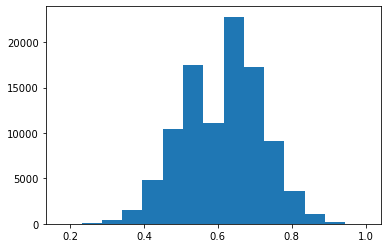

In [4]:
plt.hist(scores, bins=15)

#### What about trying random choice of 5 features after initial filter?

In [5]:
# create metrics df
def generate_metrics(df,target):    
    metrics = pd.DataFrame(index=df.columns)
    # compute percent of intensity values > 0 for esch feature
    metrics['pctvalpos'] = [sum(df[col]>0)/len(df[col]) for col in df.columns]
    # compute mutual info for features
    metrics['mi'] = mutual_info_classif(df, target, random_state=123)
    
#     # compute regular p-values for each feature between ALL/0 and AML/1 
#     pval=[]
#     for col in df.columns:
#         pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], equal_var=False)[1]) # store p-val
#     metrics['pval'] = pval
    
    # compute adjusted p-values for each feature between ALL and AML with permutations 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], \
                                    permutations=5000, random_state=123,equal_var=False)[1]) # store p-val
    metrics['adj_pval'] = pval    

    return metrics

#met = generate_metrics(train, target)
#met.describe()


In [6]:
# drop features based on metrics
def dropfeat(df, metricsdf):
    dropcol = metricsdf[metricsdf['pctvalpos'] < 0.6].index
    #dropcol = metricsdf[metricsdf['adj_pval'] > 0.01].index
    dropcol = dropcol.append(metricsdf[metricsdf['adj_pval'] > 0.0006].index)
    #dropcol = dropcol.append(metricsdf[metricsdf['pval'] > 0.001].index)
    dropcol = dropcol.append(metricsdf[metricsdf['mi'] < 0.4].index)
    
    dropcol = dropcol.unique()
    df = df.drop(dropcol, axis=1)
    #print(df.shape)
    return df

In [7]:
# distribution of scores from random choice of 5 features after metrics filter, but before correlation step

# create metrics df, drop features based on metrics
metrics = generate_metrics(trainx, trainy)
train = dropfeat(trainx, metrics)
test = dropfeat(testx, metrics)
print(f'shape after metrics filter: {train.shape}, {trainx.shape}')

# find correlated features, drop features
#corrcol = generate_corr(trainx, threshold=0.7, metricsdf=metrics)
#trainx = trainx.drop(corrcol, axis=1)
#testx = testx.drop(corrcol, axis=1)
#print(f'shape after correlation filter: {trainx.shape}')

scores=[]
for i in range(10**5):
    # pick random features
    randfeat = random.sample(list(train.columns), 5)
    train2 = train[randfeat]
    test2 = test[randfeat]


    # model pipeline
    svcpipe = Pipeline([
        ('scaler', RobustScaler()),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   

    svcpipe.fit(train2, trainy)
    scores.append(svcpipe.score(test2, testy))
    
print(f'Mean Score: {np.mean(scores)}')

shape after metrics filter: (38, 17), (38, 6733)
Mean Score: 0.8077335294117648


(array([2.2000e+01, 1.4000e+01, 2.5900e+02, 5.3800e+02, 6.7800e+02,
        3.9020e+03, 5.1430e+03, 1.5844e+04, 6.0240e+03, 5.1410e+03,
        1.5930e+04, 1.0581e+04, 2.1079e+04, 1.1141e+04, 3.7040e+03]),
 array([0.38235294, 0.42352941, 0.46470588, 0.50588235, 0.54705882,
        0.58823529, 0.62941176, 0.67058824, 0.71176471, 0.75294118,
        0.79411765, 0.83529412, 0.87647059, 0.91764706, 0.95882353,
        1.        ]),
 <BarContainer object of 15 artists>)

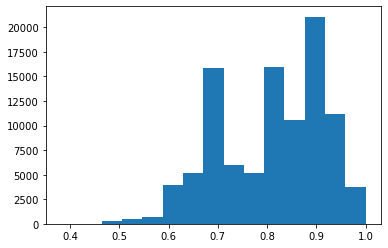

In [8]:
plt.hist(scores, bins=15)

In [9]:
# remaining features
train.columns

Index(['D10495_at', 'D88422_at', 'M21551_rna1_at', 'M23197_at', 'M27891_at',
       'M54995_at', 'M55150_at', 'M77142_at', 'M81933_at', 'M91432_at',
       'U02020_at', 'U50136_rna1_at', 'X74262_at', 'X95735_at', 'Y12670_at',
       'L09209_s_at', 'M27783_s_at'],
      dtype='object')

In [10]:
# gene descriptions of remaining features
gene_info = pd.read_csv('gene_info.csv', index_col=0)
#gene_info.head()
geneidx=[]
for genenum in train.columns:
    mask = gene_info['Gene Accession Number'].str.match(genenum)
    geneidx.append(list(gene_info[mask].index)[0])
    
print(geneidx)
gene_info.iloc[geneidx,:]

[172, 759, 1806, 1833, 1881, 2014, 2019, 2232, 2266, 2347, 2591, 3319, 4534, 4846, 5038, 6040, 6217]


,Gene Description,Gene Accession Number
172,PRKCD Protein kinase C; delta,D10495_at
759,CYSTATIN A,D88422_at
1806,Neuromedin B mRNA,M21551_rna1_at
1833,CD33 CD33 antigen (differentiation antigen),M23197_at
1881,CST3 Cystatin C (amyloid angiopathy and cerebr...,M27891_at
2014,PPBP Connective tissue activation peptide III,M54995_at
2019,FAH Fumarylacetoacetate,M55150_at
2232,NUCLEOLYSIN TIA-1,M77142_at
2266,CDC25A Cell division cycle 25A,M81933_at
2347,ACADM Acyl-Coenzyme A dehydrogenase; C-4 to C-...,M91432_at
